In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, log_loss, mean_squared_error
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from source.validate import random_split, yearly_split
from source.report import report_points, report_victory, yearly_wrapper

from source.train_funcs import train_model
from source.report import _point_to_proba
from source.validate import _make_preds

In [2]:
kfolds = KFold(n_splits=7, shuffle=True, random_state=23)

In [3]:
df = pd.read_csv('data/processed_men/training_data.csv')

df['seed_round1'] = 0
df['seed_round2'] = 0

df.loc[(df.T1_Seed < 5) & (df.stage_Round1 == 1), 'seed_round1'] = 1
df.loc[(df.T1_Seed < 2) & (df.stage_Round2 == 1), 'seed_round2'] = 1

df['off_edge_Seed'] = df['delta_Seed'] * df['delta_off_edge']
df['def_edge_Seed'] = df['delta_Seed'] * df['delta_def_edge']

df['T1_DR_edge'] = df['T1_DR_opportunity'] - df['T2_OR_opportunity']
df['T2_DR_edge'] = df['T2_DR_opportunity'] - df['T1_OR_opportunity']
df['delta_DR_edge'] = df['T1_DR_edge'] - df['T2_DR_edge']

df['T1_OR_edge'] = df['T1_OR_opportunity'] - df['T2_DR_opportunity']
df['T2_OR_edge'] = df['T2_OR_opportunity'] - df['T1_DR_opportunity']
df['delta_OR_edge'] = df['T1_OR_edge'] - df['T2_OR_edge']

df['T1_DR_rank'] = df['T1_DR'] * df['T1_Rank']
df['T2_DR_rank'] = df['T2_DR'] * df['T2_Rank']

train_df = df.copy()

train_df.head()

,Season,DayNum,Team1,Team2,target,target_points,T1_Loc,T2_Loc,ID,T1_Ast,...,off_edge_Seed,def_edge_Seed,T1_DR_edge,T2_DR_edge,delta_DR_edge,T1_OR_edge,T2_OR_edge,delta_OR_edge,T1_DR_rank,T2_DR_rank
0,2003,136,1112,1436,1,29,0,0,2003_1112_1436,17.642857,...,-222.371942,-162.787592,0.295629,0.372389,-0.076760,-0.372389,-0.295629,-0.076760,75.154018,3939.008621
1,2003,136,1113,1272,1,13,0,0,2003_1113_1272,15.551724,...,47.495336,20.227912,0.351513,0.294369,0.057144,-0.294369,-0.351513,0.057144,839.172414,565.561422
2,2003,136,1141,1166,1,6,0,0,2003_1141_1166,15.620690,...,82.336793,62.203381,0.371098,0.338259,0.032839,-0.338259,-0.371098,0.032839,1063.415948,488.991477
3,2003,136,1143,1301,1,2,0,0,2003_1143_1301,16.000000,...,-4.199504,-8.494016,0.404038,0.402327,0.001711,-0.402327,-0.404038,0.001711,887.559267,1108.552083
4,2003,136,1140,1163,0,-5,0,0,2003_1140_1163,13.419355,...,93.087056,89.004327,0.359972,0.300215,0.059756,-0.300215,-0.359972,0.059756,698.240927,774.225000


In [4]:
df = pd.read_csv('data/processed_men/2022_test_data.csv')
df.loc[:,'ID'] = df.Season.astype(str) + '_' + df.Team1.astype(str) + '_' + df.Team2.astype(str)

df['seed_round1'] = 0
df['seed_round2'] = 0

df.loc[(df.T1_Seed < 5) & (df.stage_Round1 == 1), 'seed_round1'] = 1
df.loc[(df.T1_Seed < 2) & (df.stage_Round2 == 1), 'seed_round2'] = 1

df['off_edge_Seed'] = df['delta_Seed'] * df['delta_off_edge']
df['def_edge_Seed'] = df['delta_Seed'] * df['delta_def_edge']

df['T1_DR_edge'] = df['T1_DR_opportunity'] - df['T2_OR_opportunity']
df['T2_DR_edge'] = df['T2_DR_opportunity'] - df['T1_OR_opportunity']
df['delta_DR_edge'] = df['T1_DR_edge'] - df['T2_DR_edge']

df['T1_OR_edge'] = df['T1_OR_opportunity'] - df['T2_DR_opportunity']
df['T2_OR_edge'] = df['T2_OR_opportunity'] - df['T1_DR_opportunity']
df['delta_OR_edge'] = df['T1_OR_edge'] - df['T2_OR_edge']

df['T1_DR_rank'] = df['T1_DR'] * df['T1_Rank']
df['T2_DR_rank'] = df['T2_DR'] * df['T2_Rank']

test_df = df.copy()

test_df.head()

,Team1,Team2,Pred,Season,T1_Ast,T1_Ast_diff,T1_Away,T1_Blk,T1_Blk_diff,T1_DR,...,off_edge_Seed,def_edge_Seed,T1_DR_edge,T2_DR_edge,delta_DR_edge,T1_OR_edge,T2_OR_edge,delta_OR_edge,T1_DR_rank,T2_DR_rank
0,1103,1104,0.5,2022,11.516129,1.967742,0.387097,3.096774,0.903226,23.483871,...,25.189359,55.823468,0.432253,0.428748,0.003505,-0.428748,-0.432253,0.003505,3218.967742,612.671875
1,1103,1112,0.5,2022,11.516129,1.967742,0.387097,3.096774,0.903226,23.483871,...,188.037089,184.698854,0.428580,0.436184,-0.007604,-0.436184,-0.428580,-0.007604,3218.967742,66.325630
2,1103,1116,0.5,2022,11.516129,1.967742,0.387097,3.096774,0.903226,23.483871,...,122.721173,47.126955,0.478689,0.475024,0.003665,-0.475024,-0.478689,0.003665,3218.967742,460.547619
3,1103,1120,0.5,2022,11.516129,1.967742,0.387097,3.096774,0.903226,23.483871,...,176.609695,73.763597,0.482100,0.431640,0.050459,-0.431640,-0.482100,0.050459,3218.967742,140.993862
4,1103,1124,0.5,2022,11.516129,1.967742,0.387097,3.096774,0.903226,23.483871,...,175.852254,121.200264,0.422002,0.432706,-0.010704,-0.432706,-0.422002,-0.010704,3218.967742,85.718750


In [5]:
to_use = ['ID', 'Team1', 'Team2', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'Ast', 'Blk', 'Away', 'DR', 'FGA', 'FGA3', 'FGM',
        'off_rating', 'def_rating', 'Rank', 'DR_rank',
        'FGM3', 'OR', 'Stl', 'TO', 'FGM_perc', 'FGM3_perc', 'high_seed', 'low_seed']
l2wd_car = []
l2wt_car = ['Score', 'FGM_perc', 'TO_perposs']

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    
to_use_xgb = to_use

to_use_xgb

['ID',
 'Team1',
 'Team2',
 'target',
 'Season',
 'target_points',
 'T1_Score',
 'T2_Score',
 'T1_Ast',
 'T2_Ast',
 'T1_Blk',
 'T2_Blk',
 'T1_Away',
 'T2_Away',
 'T1_DR',
 'T2_DR',
 'T1_FGA',
 'T2_FGA',
 'T1_FGA3',
 'T2_FGA3',
 'T1_FGM',
 'T2_FGM',
 'T1_off_rating',
 'T2_off_rating',
 'T1_def_rating',
 'T2_def_rating',
 'T1_Rank',
 'T2_Rank',
 'T1_DR_rank',
 'T2_DR_rank',
 'T1_FGM3',
 'T2_FGM3',
 'T1_OR',
 'T2_OR',
 'T1_Stl',
 'T2_Stl',
 'T1_TO',
 'T2_TO',
 'T1_FGM_perc',
 'T2_FGM_perc',
 'T1_FGM3_perc',
 'T2_FGM3_perc',
 'T1_high_seed',
 'T2_high_seed',
 'T1_low_seed',
 'T2_low_seed',
 'T1_L2W_Score',
 'T2_L2W_Score',
 'T1_L2W_FGM_perc',
 'T2_L2W_FGM_perc',
 'T1_L2W_TO_perposs',
 'T2_L2W_TO_perposs']

In [6]:
to_use = ['ID', 'Team1', 'Team2', 'target', 'Season']

d_car = ['Score', 'opp_score', 
       'Stl', 'off_rating', 'def_rating', 'DR_edge', 'OR', 'TO', 'Rank', 'high_seed']
t_car = []
l2wd_car = ['opp_score', 'FGM_perc', 'possessions', 'Away']
l2wt_car = []

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    

to_use += ['seed_round1', 'seed_round2', 'off_edge_Seed', 'def_edge_Seed']

to_use_logit = to_use

to_use_logit

['ID',
 'Team1',
 'Team2',
 'target',
 'Season',
 'delta_Score',
 'delta_opp_score',
 'delta_Stl',
 'delta_off_rating',
 'delta_def_rating',
 'delta_DR_edge',
 'delta_OR',
 'delta_TO',
 'delta_Rank',
 'delta_high_seed',
 'delta_L2W_opp_score',
 'delta_L2W_FGM_perc',
 'delta_L2W_possessions',
 'delta_L2W_Away',
 'seed_round1',
 'seed_round2',
 'off_edge_Seed',
 'def_edge_Seed']

# Logit Training

In [7]:
logit_target = train_df['target']
logit_index = train_df[['ID', 'Team1', 'Team2', 'target', 'Season']].copy()
logit_train = train_df[[col for col in to_use_logit if col not in ['ID', 'Team1', 'Team2', 'target', 'Season']]].copy()
logit_train.head()

,delta_Score,delta_opp_score,delta_Stl,delta_off_rating,delta_def_rating,delta_DR_edge,delta_OR,delta_TO,delta_Rank,delta_high_seed,delta_L2W_opp_score,delta_L2W_FGM_perc,delta_L2W_possessions,delta_L2W_Away,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed
0,17.421182,7.112069,1.602217,7.988909,-4.016619,-0.076760,2.213054,0.716749,-150.40625,0.777778,21.666667,-0.074627,16.808333,-0.75,1,0,-222.371942,-162.787592
1,1.448276,3.344828,-2.172414,3.736976,5.352166,0.057144,-0.379310,0.206897,14.21875,-0.466667,8.750000,0.048098,4.156250,-0.75,0,0,47.495336,20.227912
2,0.102403,8.908046,-1.290491,-4.266093,8.292775,0.032839,-0.292581,4.877743,24.59375,-0.500000,6.150000,0.049300,1.266250,0.05,0,0,82.336793,62.203381
3,2.082759,1.758621,-1.214943,-1.975824,-2.318688,0.001711,1.508046,-0.027586,-13.90625,0.178571,-5.750000,-0.044297,1.060417,-0.25,0,0,-4.199504,-8.494016
4,-7.581720,-7.722581,1.002151,2.493947,-1.910700,0.059756,-3.895699,-2.058065,0.84375,-0.500000,-3.066667,-0.006115,-7.450000,-0.10,0,0,93.087056,89.004327


In [8]:
logit_res = test_df[['ID', 'Team1', 'Team2', 'Season']].copy()
logit_test = test_df[[col for col in to_use_logit if col not in ['ID', 'Team1', 'Team2', 'target', 'Season']]].copy()
logit_test.head()

,delta_Score,delta_opp_score,delta_Stl,delta_off_rating,delta_def_rating,delta_DR_edge,delta_OR,delta_TO,delta_Rank,delta_high_seed,delta_L2W_opp_score,delta_L2W_FGM_perc,delta_L2W_possessions,delta_L2W_Away,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed
0,-10.678427,-12.244960,-1.516129,-0.078934,-4.297367,0.003505,-3.754032,-3.255040,112.285714,-0.545455,-22.800000,0.047177,-16.503333,0.800000,0,0,25.189359,55.823468
1,-15.268501,-3.368121,-1.222011,-7.495725,7.773911,-0.007604,-2.570209,-2.102467,134.732143,-0.714286,-11.300000,-0.083446,-6.249167,0.133333,0,0,188.037089,184.698854
2,-7.649071,-4.384164,-2.243402,2.659518,5.739839,0.003665,-1.826002,-1.312805,119.000000,-0.750000,-15.550000,0.032347,-10.195000,0.550000,0,0,122.721173,47.126955
3,-9.428427,-2.869960,-3.297379,1.190065,8.159580,0.050459,-2.347782,-0.817540,131.589286,-0.625000,-8.466667,0.059675,-13.886667,0.466667,0,0,176.609695,73.763597
4,-7.209677,0.536290,-3.328629,-2.204175,6.758508,-0.010704,-3.097782,-1.161290,133.303571,-0.555556,-6.800000,0.028736,-3.745000,0.466667,0,0,175.852254,121.200264


In [9]:
logit_pipe = Pipeline([('scl', tml.DfScaler(method='robust')),
                 ('logit', LogisticRegression(random_state=23, C=0.04))])

In [10]:
grid_param = {'logit__C': np.arange(0.01, 2, 0.01), 'scl__method': ['robust','standard']}

res, bp, be = tml.grid_search(logit_train, logit_target, logit_pipe, grid_param, 'neg_log_loss', kfolds)

print(bp)

res

{'logit__C': 0.03, 'scl__method': 'robust'}


,param_logit__C,param_scl__method,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0.03,robust,-0.526580,0.001785,-0.533436,0.010212,0.013173,0.000397,0.003369,0.000073
1,0.02,robust,-0.527442,0.001781,-0.533517,0.009935,0.012982,0.000364,0.003423,0.000063
2,0.04,robust,-0.526153,0.001783,-0.533548,0.010357,0.013346,0.000518,0.003365,0.000076
3,0.05,robust,-0.525898,0.001780,-0.533695,0.010443,0.013751,0.000166,0.003386,0.000049
4,0.06,robust,-0.525729,0.001776,-0.533844,0.010494,0.014024,0.000394,0.003369,0.000080
...,...,...,...,...,...,...,...,...,...,...
393,1.95,standard,-0.524987,0.001693,-0.536618,0.009755,0.013746,0.000331,0.003194,0.000067
394,1.96,standard,-0.524987,0.001693,-0.536619,0.009755,0.014250,0.000665,0.003364,0.000054
395,1.97,standard,-0.524987,0.001693,-0.536620,0.009756,0.014209,0.000412,0.003312,0.000039
396,1.98,standard,-0.524987,0.001693,-0.536621,0.009755,0.014633,0.000735,0.003502,0.000228


In [11]:
logit_pipe = Pipeline([('scl', tml.DfScaler(method='robust')),
                 ('logit', LogisticRegression(random_state=23, C=0.03))])

In [12]:
_, logit_index['oof_pred'], feat_imp, logit_res['logit_pred'] = _make_preds(logit_train, logit_target, logit_test, logit_pipe, kfolds, predict_proba=True)
feat_imp

,mean,std
feat,,
delta_Rank,-0.471312,0.009415
def_edge_Seed,-0.317328,0.010631
off_edge_Seed,-0.312318,0.009578
delta_OR,0.259377,0.006321
delta_off_rating,0.252119,0.019911
delta_Stl,0.219051,0.014325
delta_high_seed,0.184739,0.012117
delta_opp_score,-0.169101,0.012384
delta_L2W_possessions,-0.152930,0.012297


In [13]:
logit_index.head()

,ID,Team1,Team2,target,Season,oof_pred
0,2003_1112_1436,1112,1436,1,2003,0.931416
1,2003_1113_1272,1113,1272,1,2003,0.304629
2,2003_1141_1166,1141,1166,1,2003,0.181768
3,2003_1143_1301,1143,1301,1,2003,0.498632
4,2003_1140_1163,1140,1163,0,2003,0.391805


<AxesSubplot:>

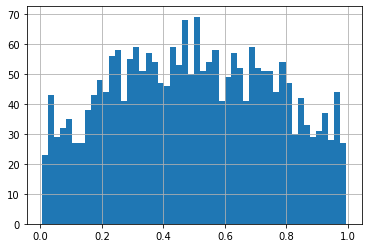

In [14]:
logit_index['oof_pred'].hist(bins=50)

Accuracy train: 		 0.7045
Accuracy test: 			 0.7045
Logloss train: 			 0.5338
Logloss test: 			 0.5338
Unsure train: 			 24.5383%
Unsure test: 			 24.5383%


,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test
0,0.7045,0.7045,0.5338,0.5338,24.5383,24.5383


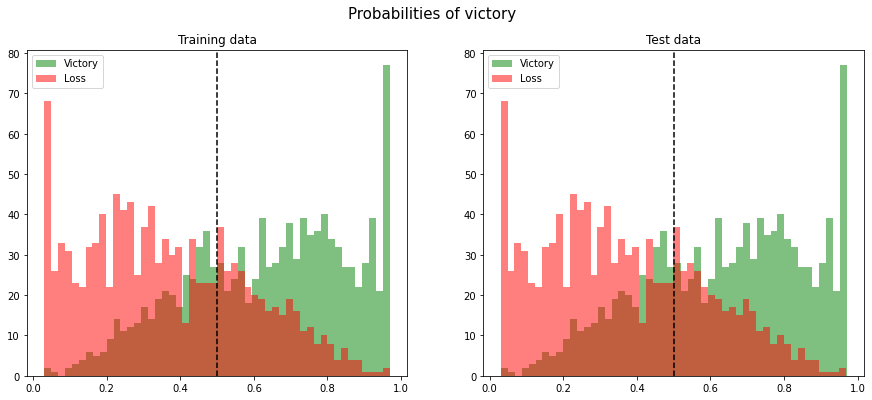

In [15]:
report_victory(logit_target, logit_target, logit_index['oof_pred'], logit_index['oof_pred'], probs=True, plot=True)

In [16]:
logit_res.head()

,ID,Team1,Team2,Season,logit_pred
0,2022_1103_1104,1103,1104,2022,0.277327
1,2022_1103_1112,1103,1112,2022,0.047798
2,2022_1103_1116,1103,1116,2022,0.156540
3,2022_1103_1120,1103,1120,2022,0.101171
4,2022_1103_1124,1103,1124,2022,0.065716


<AxesSubplot:>

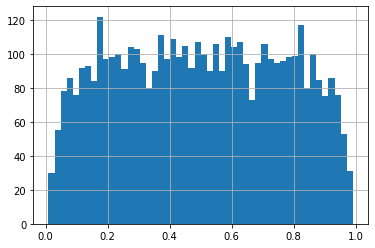

In [17]:
logit_res.logit_pred.hist(bins=50)

# XGB train

In [18]:
def cauchyobj(labels, preds):
    c = 3000 
    x =  preds - labels    
    grad = x / (x**2 / c**2 + 1)
    hess = - c**2 *(x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

In [19]:
xgb_target = train_df['target_points']
xgb_index = train_df[['ID', 'Team1', 'Team2', 'target_points', 'target', 'Season']].copy()
xgb_train = train_df[[col for col in to_use_xgb if col not in ['ID', 'Team1', 'Team2', 'target', 'target_points', 'Season']]].copy()
xgb_train.head()

,T1_Score,T2_Score,T1_Ast,T2_Ast,T1_Blk,T2_Blk,T1_Away,T2_Away,T1_DR,T2_DR,...,T1_high_seed,T2_high_seed,T1_low_seed,T2_low_seed,T1_L2W_Score,T2_L2W_Score,T1_L2W_FGM_perc,T2_L2W_FGM_perc,T1_L2W_TO_perposs,T2_L2W_TO_perposs
0,85.214286,67.793103,17.642857,14.206897,4.214286,2.965517,0.392857,0.344828,27.642857,25.724138,...,0.777778,0.000000,0.947368,0.655172,83.00,68.25,0.413636,0.488263,0.145423,0.196868
1,75.965517,74.517241,15.551724,16.620690,4.241379,5.068966,0.206897,0.310345,23.310345,25.965517,...,0.200000,0.666667,0.842105,0.826087,79.75,74.50,0.489540,0.441441,0.182989,0.181711
2,79.344828,79.242424,15.620690,16.818182,4.000000,4.454545,0.413793,0.363636,23.275862,23.181818,...,0.000000,0.500000,0.793103,0.903226,83.40,73.25,0.516260,0.466960,0.242059,0.200904
3,74.482759,72.400000,16.000000,14.666667,2.793103,3.066667,0.275862,0.166667,24.379310,22.033333,...,0.428571,0.250000,0.818182,0.727273,67.75,72.50,0.421277,0.465574,0.196615,0.214473
4,72.451613,80.033333,13.419355,15.633333,2.516129,7.733333,0.322581,0.233333,24.419355,27.900000,...,0.000000,0.500000,0.793103,0.750000,75.60,74.50,0.467857,0.473973,0.138380,0.228041


In [20]:
xgb_index.shape

(2274, 6)

In [21]:
xgb_res = test_df[['ID', 'Team1', 'Team2', 'Season']].copy()
xgb_test = test_df[[col for col in to_use_xgb if col not in ['ID', 'Team1', 'Team2', 'target', 'target_points', 'Season']]].copy()
xgb_test.head()

,T1_Score,T2_Score,T1_Ast,T2_Ast,T1_Blk,T2_Blk,T1_Away,T2_Away,T1_DR,T2_DR,...,T1_high_seed,T2_high_seed,T1_low_seed,T2_low_seed,T1_L2W_Score,T2_L2W_Score,T1_L2W_FGM_perc,T2_L2W_FGM_perc,T1_L2W_TO_perposs,T2_L2W_TO_perposs
0,69.290323,79.968750,11.516129,14.625000,3.096774,4.718750,0.387097,0.187500,23.483871,24.718750,...,0.0,0.545455,0.733333,0.619048,70.2,74.666667,0.448276,0.401099,0.144507,0.235586
1,69.290323,84.558824,11.516129,19.911765,3.096774,5.705882,0.387097,0.411765,23.483871,28.352941,...,0.0,0.714286,0.733333,0.962963,70.2,85.166667,0.448276,0.531722,0.144507,0.149739
2,69.290323,76.939394,11.516129,14.090909,3.096774,4.181818,0.387097,0.242424,23.483871,25.484848,...,0.0,0.750000,0.733333,0.760000,70.2,73.500000,0.448276,0.415929,0.144507,0.183542
3,69.290323,78.718750,11.516129,14.531250,3.096774,7.843750,0.387097,0.343750,23.483871,25.718750,...,0.0,0.625000,0.733333,0.916667,70.2,75.000000,0.448276,0.388601,0.144507,0.158520
4,69.290323,76.500000,11.516129,15.843750,3.096774,3.406250,0.387097,0.343750,23.483871,22.750000,...,0.0,0.555556,0.733333,0.913043,70.2,70.000000,0.448276,0.419540,0.144507,0.139982


In [22]:
proc_pipe = Pipeline([('scl', tml.DfScaler(method='standard'))])
estimator = xgb.XGBRegressor(learning_rate=0.05, n_estimators=4000, objective=cauchyobj, max_depth=3,
                                           n_jobs=5, subsample=0.35, reg_alpha=1, reg_lambda=10, colsample_bytree=0.7)
# estimator = xgb.XGBRegressor(learning_rate=0.05, n_estimators=4000, objective=cauchyobj, max_depth=4,
#                                            n_jobs=5, subsample=0.35, reg_alpha=1, reg_lambda=1, colsample_bytree=0.65)


xgb_index['oof_pointpred'], xgb_res['xgb_pointpred'], rep_res = train_model(xgb_train, xgb_test, xgb_target,
                                                                       proc_pipe, estimator, kfolds, early_stopping=200, eval_metric='mae')

In [23]:
rep_res['n_iterations']

[325, 389, 51, 87, 142, 422, 153]

In [24]:
rep_res['feat_imp']

,mean,std
feat,,
T2_DR_rank,0.087349,0.002998
T1_DR_rank,0.087087,0.002418
T2_Rank,0.063443,0.003293
T1_Rank,0.057275,0.004481
T1_high_seed,0.025770,0.002030
T2_low_seed,0.021170,0.001304
T2_high_seed,0.021058,0.001428
T1_low_seed,0.020499,0.000662
T1_off_rating,0.018272,0.000407


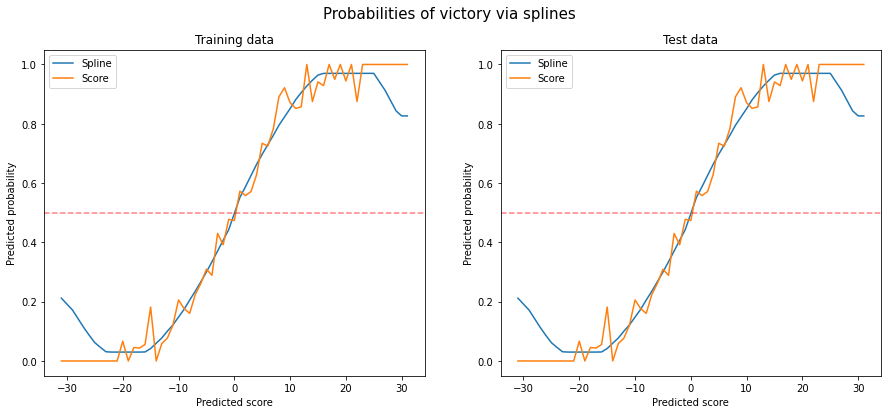

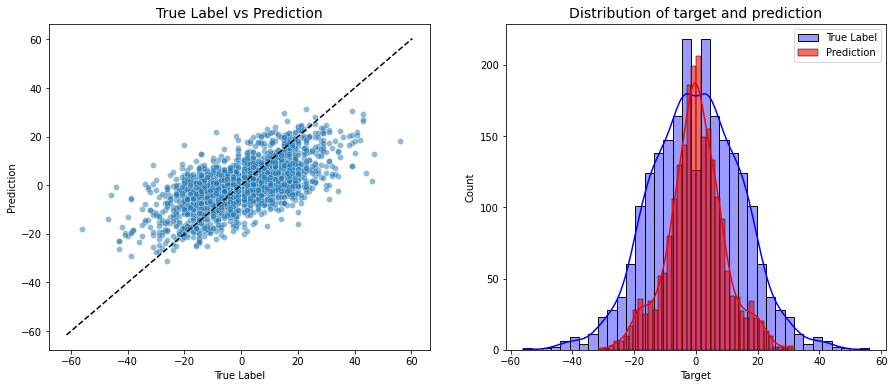

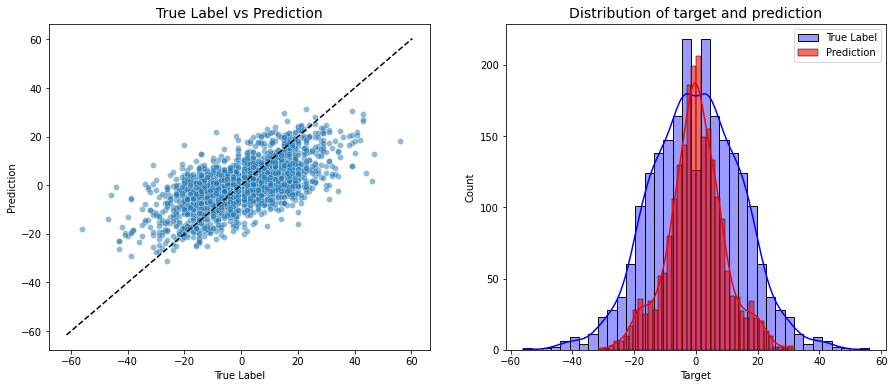

MAE train: 			 8.6683
MAE test: 			 8.6683
RMSE train: 			 11.1293
RMSE test: 			 11.1293
Accuracy train: 		 0.7155
Accuracy test: 			 0.7155
Logloss train: 			 0.5324
Logloss test: 			 0.5324
Unsure train: 			 21.81%
Unsure test: 			 21.81%


,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test
0,8.6683,8.6683,11.1293,11.1293,0.7155,0.7155,0.5324,0.5324,21.81,21.81


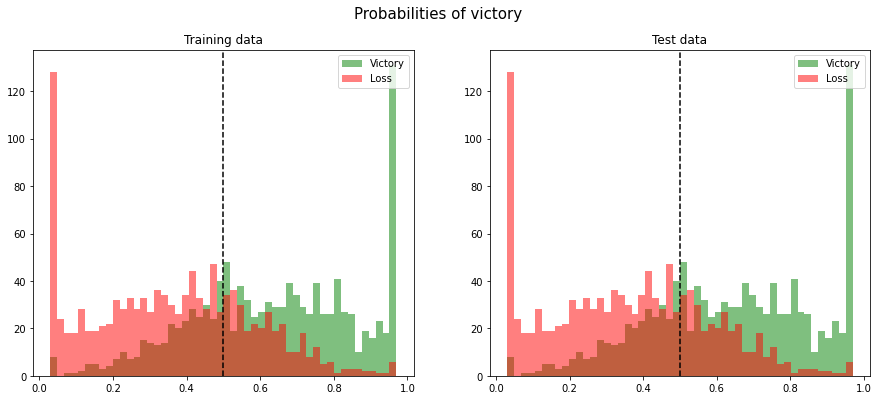

In [25]:
report_points(xgb_train, xgb_train, xgb_target, xgb_target, xgb_index['oof_pointpred'], xgb_index['oof_pointpred'], plot=True)

In [26]:
xgb_index['oof_pred'], xgb_res['xgb_pred'] = _point_to_proba(xgb_index['oof_pointpred'], xgb_index['target'], xgb_res['xgb_pointpred'])

In [27]:
xgb_index.head()

,ID,Team1,Team2,target_points,target,Season,oof_pointpred,oof_pred
0,2003_1112_1436,1112,1436,29,1,2003,22.132580,0.970000
1,2003_1113_1272,1113,1272,13,1,2003,0.564139,0.518373
2,2003_1141_1166,1141,1166,6,1,2003,-7.345628,0.239462
3,2003_1143_1301,1143,1301,2,1,2003,0.104384,0.501401
4,2003_1140_1163,1140,1163,-5,0,2003,-1.563294,0.440020


<AxesSubplot:>

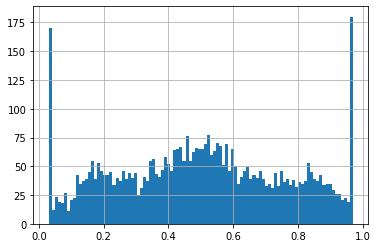

In [28]:
xgb_res['xgb_pred'].hist(bins=100)

# Combining

Accord: 	0.8808267370272648
Logit: 		0.5334372141898157
Xgb: 		0.5324056592450976
Mean: 		0.5271868147779862
Boost sure: 	0.5330100819082294
Boost sure+mean: 0.5315311945087922
No uncertain: 0.5517236225492259
Accuracy train: 		 0.7146
Accuracy test: 			 0.7124
Logloss train: 			 0.533
Logloss test: 			 0.5273
Unsure train: 			 29.1557%
Unsure test: 			 27.4406%


,ID,Team1,Team2,target,Season,logit_pred,target_points,oof_pointpred,xgb_pred,mean_pred,accord_win,accord_loss,accord,boostsure,avg_boost,no_uncertain
0,2003_1112_1436,1112,1436,1,2003,0.931416,29,22.132580,0.970000,0.950708,1,0,1,0.970000,0.970000,0.970000
1,2003_1113_1272,1113,1272,1,2003,0.304629,13,0.564139,0.518373,0.411501,0,0,0,0.518373,0.518373,0.518373
2,2003_1141_1166,1141,1166,1,2003,0.181768,6,-7.345628,0.239462,0.210615,0,1,1,0.239462,0.210615,0.139462
3,2003_1143_1301,1143,1301,1,2003,0.498632,2,0.104384,0.501401,0.500017,0,0,0,0.501401,0.501401,0.501401
4,2003_1140_1163,1140,1163,0,2003,0.391805,-5,-1.563294,0.440020,0.415913,0,1,1,0.440020,0.415913,0.340020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2269,2021_1425_1211,1425,1211,0,2021,0.181695,-19,-5.993093,0.283585,0.232640,0,1,1,0.283585,0.232640,0.183585
2270,2021_1417_1276,1417,1276,1,2021,0.225326,2,-2.842076,0.393523,0.309424,0,1,1,0.393523,0.309424,0.293523
2271,2021_1222_1124,1222,1124,0,2021,0.551469,-19,-5.705071,0.293259,0.422364,0,0,0,0.293259,0.293259,0.293259
2272,2021_1417_1211,1417,1211,0,2021,0.081562,-3,-11.883063,0.112050,0.096806,0,1,1,0.030000,0.030000,0.030000


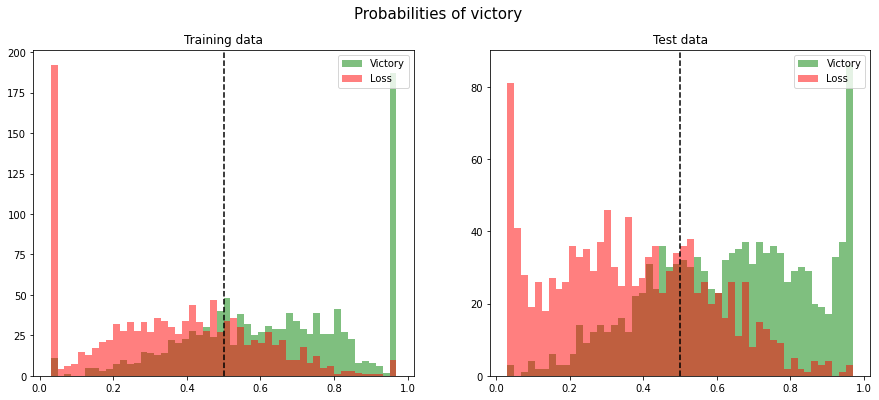

In [29]:
logit_index.rename(columns={'oof_pred': 'logit_pred'}, inplace=True)
xgb_index.rename(columns={'oof_pred': 'xgb_pred'}, inplace=True)

all_pred = pd.merge(logit_index, xgb_index, on=['ID', 'Team1', 'Team2', 'Season', 'target'])
lim = 0.35
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

all_pred['boostsure'] = all_pred.xgb_pred

all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

all_pred['no_uncertain'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              ((all_pred.logit_pred < 0.5+lim) | (all_pred.xgb_pred < 0.5+lim))), 'no_uncertain'] = all_pred['no_uncertain'] + 0.1
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              ((all_pred.logit_pred > 0.5-lim) | (all_pred.xgb_pred > 0.5-lim))), 'no_uncertain'] = all_pred['no_uncertain'] - 0.1
all_pred['no_uncertain'] = np.clip(all_pred['no_uncertain'], 0.03, 0.97)


print(f'Accord: \t{all_pred.accord.mean()}')
print(f'Logit: \t\t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.target)}')
print(f'Xgb: \t\t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.target)}')
print(f'Mean: \t\t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.target)}')
print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.target)}')
print(f'Boost sure+mean: {log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.target)}')
print(f'No uncertain: {log_loss(y_pred=all_pred.no_uncertain, y_true=all_pred.target)}')
report_victory(all_pred.target, all_pred.target, all_pred.boostsure, all_pred.mean_pred, probs=True, plot=True)
all_pred

In [30]:
all_pred = pd.merge(logit_res, xgb_res, on=['ID', 'Team1', 'Team2', 'Season'])
lim = 0.35
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

all_pred['boostsure'] = all_pred.xgb_pred

all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

all_pred['no_uncertain'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              ((all_pred.logit_pred < 0.5+lim) | (all_pred.xgb_pred < 0.5+lim))), 'no_uncertain'] = all_pred['no_uncertain'] + 0.05
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              ((all_pred.logit_pred > 0.5-lim) | (all_pred.xgb_pred > 0.5-lim))), 'no_uncertain'] = all_pred['no_uncertain'] - 0.05
all_pred['no_uncertain'] = np.clip(all_pred['no_uncertain'], 0.03, 0.97)

all_pred

,ID,Team1,Team2,Season,logit_pred,xgb_pointpred,xgb_pred,mean_pred,accord_win,accord_loss,accord,boostsure,avg_boost,no_uncertain
0,2022_1103_1104,1103,1104,2022,0.277327,-10.474685,0.147614,0.212470,0,1,1,0.147614,0.147614,0.097614
1,2022_1103_1112,1103,1112,2022,0.047798,-19.213160,0.030000,0.038899,0,1,1,0.030000,0.030000,0.030000
2,2022_1103_1116,1103,1116,2022,0.156540,-9.825286,0.165318,0.160929,0,1,1,0.165318,0.160929,0.115318
3,2022_1103_1120,1103,1120,2022,0.101171,-16.066999,0.033598,0.067384,0,1,1,0.030000,0.030000,0.030000
4,2022_1103_1124,1103,1124,2022,0.065716,-18.045229,0.030000,0.047858,0,1,1,0.030000,0.030000,0.030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,2022_1461_1458,1461,1458,2022,0.287370,-2.796677,0.395160,0.341265,0,1,1,0.395160,0.341265,0.345160
4552,2022_1463_1458,1463,1458,2022,0.170211,-9.125777,0.185234,0.177722,0,1,1,0.185234,0.177722,0.135234
4553,2022_1461_1460,1461,1460,2022,0.749446,5.200252,0.685969,0.717708,1,0,1,0.685969,0.717708,0.735969
4554,2022_1463_1460,1463,1460,2022,0.562302,-1.331453,0.448518,0.505410,0,0,0,0.448518,0.448518,0.448518


array([[<AxesSubplot:title={'center':'Team1'}>,
        <AxesSubplot:title={'center':'Team2'}>,
        <AxesSubplot:title={'center':'Season'}>,
        <AxesSubplot:title={'center':'logit_pred'}>],
       [<AxesSubplot:title={'center':'xgb_pointpred'}>,
        <AxesSubplot:title={'center':'xgb_pred'}>,
        <AxesSubplot:title={'center':'mean_pred'}>,
        <AxesSubplot:title={'center':'accord_win'}>],
       [<AxesSubplot:title={'center':'accord_loss'}>,
        <AxesSubplot:title={'center':'accord'}>,
        <AxesSubplot:title={'center':'boostsure'}>,
        <AxesSubplot:title={'center':'avg_boost'}>],
       [<AxesSubplot:title={'center':'no_uncertain'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

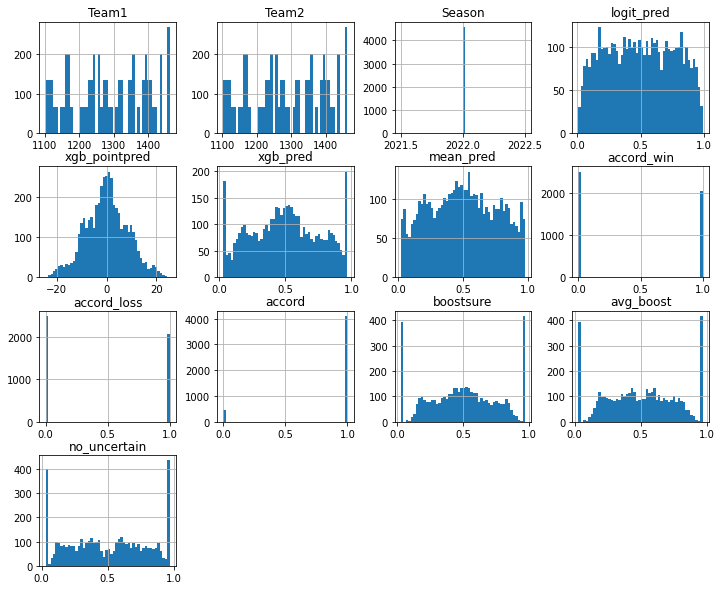

In [31]:
all_pred.hist(bins=50, figsize=(12, 10))


# Spread submission

In [32]:
normal_scores = xgb_res[xgb_res.Team1 < xgb_res.Team2]#[['ID', 'Team1', 'Team2', 'xgb_pred', 'xgb_pointpred']]
opp_scores = xgb_res[xgb_res.Team1 > xgb_res.Team2].copy()#[['ID', 'Team1', 'Team2', 'xgb_pred', 'xgb_pointpred']].copy()
opp_scores.drop(['ID', 'Season'], axis=1, inplace=True)
tot_scores = pd.merge(normal_scores, opp_scores, left_on=['Team1', 'Team2'], right_on=['Team2', 'Team1'])
tot_scores['xgb_preds'] = (tot_scores['xgb_pred_x'] + 1 -  tot_scores['xgb_pred_y']) / 2
tot_scores['Pred'] = round((tot_scores['xgb_pointpred_x'] -  tot_scores['xgb_pointpred_y']) / 2, 0).astype(int)

#tot_scores[['ID', 'Pred']].to_csv('oof/2021_men_submission_spread.csv', index=False)

tot_scores.head()

,ID,Team1_x,Team2_x,Season,xgb_pointpred_x,xgb_pred_x,Team1_y,Team2_y,xgb_pointpred_y,xgb_pred_y,xgb_preds,Pred
0,2021_1101_1104,1101,1104,2021,-11.139761,0.125821,1104,1101,11.174927,0.875802,0.125009,-11
1,2021_1101_1111,1101,1111,2021,4.880082,0.679685,1111,1101,-4.192175,0.345202,0.667241,5
2,2021_1101_1116,1101,1116,2021,-11.674033,0.112354,1116,1101,12.746707,0.913584,0.099385,-12
3,2021_1101_1124,1101,1124,2021,-14.882341,0.045740,1124,1101,16.095044,0.970000,0.037870,-15
4,2021_1101_1140,1101,1140,2021,-3.477293,0.371025,1140,1101,6.069996,0.720977,0.325024,-5


In [48]:
def find_match(team1, team2):
    res = tot_scores[(tot_scores.Name1.str.contains(team1) & tot_scores.Name2.str.contains(team2)) | 
                     (tot_scores.Name2.str.contains(team1) & tot_scores.Name1.str.contains(team2))]
    return res

find_match('West Virginia', 'Moreh')

,ID,Team1,Team2,mean_pred,boostsure,avg_boost,T1_Seed,T2_Seed,stage_Round1,stage_Round2,stage_Round3,stage_Round4,stage_final,stage_finalfour,stage_impossible,Name1,Name2
1746,2021_1287_1452,1287,1452,0.127279,0.097503,0.097503,14.0,3.0,1,0,0,0,0,0,0,Morehead St,West Virginia


In [49]:
results = pd.DataFrame({'ID': ['2021_1196_1439', '2021_1116_1159', '2021_1180_1228', '2021_1403_1429', 
                               '2021_1326_1331', '2021_1124_1216', '2021_1210_1260', '2021_1333_1397', 
                               '2021_1251_1329', '2021_1314_1458', '2021_1156_1222', '2021_1317_1345', 
                               '2021_1155_1353', '2021_1361_1393', '2021_1437_1457', '2021_1287_1452'], 
                        'Result': [5, 17, -29, 12, 
                                   -3, 24, -9, 14, 
                                   -9, -23, -32, 9, 
                                   -4, 16, 10, -17]})

pred = pd.read_csv('oof/2021_men_submission_spread.csv')
tot = pd.merge(results, pred, how='left')
print(mean_squared_error(tot.Result, tot.Pred, squared=False))
print(mean_absolute_error(tot.Result, tot.Pred))
tot

11.269427669584644
9.875


,ID,Result,Pred
0,2021_1196_1439,5,-1
1,2021_1116_1159,17,6
2,2021_1180_1228,-29,-19
3,2021_1403_1429,12,4
4,2021_1326_1331,-3,10
5,2021_1124_1216,24,20
6,2021_1210_1260,-9,1
7,2021_1333_1397,14,-7
8,2021_1251_1329,-9,-6
9,2021_1314_1458,-23,-2


In [50]:
pred = pd.read_csv('oof/2021_men_submission_spread2.csv')
tot = pd.merge(results, pred, how='left')
print(mean_squared_error(tot.Result, tot.Pred, squared=False))
print(mean_absolute_error(tot.Result, tot.Pred))
tot

11.720708169731042
10.125


,ID,Result,Pred
0,2021_1196_1439,5,0
1,2021_1116_1159,17,5
2,2021_1180_1228,-29,-19
3,2021_1403_1429,12,3
4,2021_1326_1331,-3,13
5,2021_1124_1216,24,20
6,2021_1210_1260,-9,0
7,2021_1333_1397,14,-6
8,2021_1251_1329,-9,-8
9,2021_1314_1458,-23,-1


# Main submission

In [32]:
normal_scores = all_pred[all_pred.Team1 < all_pred.Team2]
opp_scores = all_pred[all_pred.Team1 > all_pred.Team2].copy()
opp_scores.drop(['ID', 'Season'], axis=1, inplace=True)
tot_scores = pd.merge(normal_scores, opp_scores, left_on=['Team1', 'Team2'], right_on=['Team2', 'Team1'])
tot_scores['mean_pred'] = (tot_scores['mean_pred_x'] + 1 -  tot_scores['mean_pred_y']) / 2
tot_scores['boostsure'] = (tot_scores['boostsure_x'] + 1 -  tot_scores['boostsure_y']) / 2
tot_scores['avg_boost'] = (tot_scores['avg_boost_x'] + 1 -  tot_scores['avg_boost_y']) / 2

tot_scores.rename(columns={'Team1_x': 'Team1', 'Team2_x': 'Team2'}, inplace=True)

tot_scores = tot_scores[['ID', 'Team1', 'Team2', 'mean_pred', 'boostsure', 'avg_boost']].copy()

tot_scores = pd.merge(tot_scores, 
                      test_df[['Team1', 'Team2', 'T1_Seed', 'T2_Seed'] + [col for col in test_df if 'stage' in col]], 
                      on=['Team1', 'Team2'], how='left')

teams = pd.read_csv('data/raw_men/MDataFiles_Stage2/MTeams.csv')[['TeamID', 'TeamName']]

teams.rename(columns={'TeamID': 'Team1', 'TeamName': 'Name1'}, inplace=True)
tot_scores = pd.merge(tot_scores, teams, on='Team1', how='left')
teams.rename(columns={'Team1': 'Team2', 'Name1': 'Name2'}, inplace=True)
tot_scores = pd.merge(tot_scores, teams, on='Team2', how='left')

tot_scores

,ID,Team1,Team2,mean_pred,boostsure,avg_boost,T1_Seed,T2_Seed,stage_Round1,stage_Round2,stage_Round3,stage_Round4,stage_final,stage_finalfour,stage_impossible,Name1,Name2
0,2022_1103_1104,1103,1104,0.211536,0.143985,0.143985,13.0,6.0,0,0,0,0,0,1,0,Akron,Alabama
1,2022_1103_1112,1103,1112,0.039084,0.030000,0.030000,13.0,1.0,0,0,0,0,1,0,0,Akron,Arizona
2,2022_1103_1116,1103,1116,0.160144,0.162864,0.160144,13.0,4.0,0,0,0,0,0,1,0,Akron,Arkansas
3,2022_1103_1120,1103,1120,0.066765,0.030000,0.030000,13.0,2.0,0,0,0,0,1,0,0,Akron,Auburn
4,2022_1103_1124,1103,1124,0.048077,0.030000,0.030000,13.0,1.0,0,0,1,0,0,0,0,Akron,Baylor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2022_1458_1461,1458,1461,0.665046,0.619068,0.665046,3.0,12.0,0,0,0,0,1,0,0,Wisconsin,Wyoming
2274,2022_1458_1463,1458,1463,0.816935,0.805355,0.816935,3.0,14.0,0,0,0,0,1,0,0,Wisconsin,Yale
2275,2022_1460_1461,1460,1461,0.281450,0.313782,0.281450,16.0,12.0,0,0,0,0,1,0,0,Wright St,Wyoming
2276,2022_1460_1463,1460,1463,0.484169,0.532531,0.532531,16.0,14.0,0,0,0,0,1,0,0,Wright St,Yale


In [38]:
tot_scores[['ID', 'mean_pred']].rename(columns={'mean_pred':'Pred'}).to_csv('oof/2022_men_sub_mean.csv', index=False)
tot_scores[['ID', 'boostsure']].rename(columns={'boostsure':'Pred'}).to_csv('oof/2022_men_sub_boostsure.csv', index=False)


In [2]:
def find_match(team1, team2):
    res = tot_scores[(tot_scores.Name1.str.contains(team1) & tot_scores.Name2.str.contains(team2)) | 
                     (tot_scores.Name2.str.contains(team1) & tot_scores.Name1.str.contains(team2))]
    return res

In [105]:
find_match('Purdue', 'North Texas')

,ID,Team1,Team2,mean_pred,boostsure,avg_boost,T1_Seed,T2_Seed,stage_Round1,stage_Round2,stage_Round3,stage_Round4,stage_final,stage_finalfour,stage_impossible,Name1,Name2
1850,2021_1317_1345,1317,1345,0.299602,0.281963,0.299602,13.0,4.0,1,0,0,0,0,0,0,North Texas,Purdue


In [84]:
adjusted = tot_scores.copy()
adjusted.loc[(adjusted.Team1 == 1211) & adjusted.Team2 == 1313, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1111) & adjusted.Team2 == 1211, 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 1281) & adjusted.Team2 == 1328, 'Pred'] = 0.35  #####
adjusted.loc[(adjusted.Team1 == 1166) & adjusted.Team2 == 1364, 'Pred'] = 0.72
adjusted.loc[(adjusted.Team1 == 1325) & adjusted.Team2 == 1438, 'Pred'] = 0.14
adjusted.loc[(adjusted.Team1 == 1186) & adjusted.Team2 == 1242, 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 1332) & adjusted.Team2 == 1433, 'Pred'] = 0.65  ######
adjusted.loc[(adjusted.Team1 == 1231) & adjusted.Team2 == 1234, 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 1124) & adjusted.Team2 == 1216, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1314) & adjusted.Team2 == 1458, 'Pred'] = 0.35  ######
adjusted.loc[(adjusted.Team1 == 1403) & adjusted.Team2 == 1429, 'Pred'] = 0.67  #### Or do nothing
adjusted.loc[(adjusted.Team1 == 1116) & adjusted.Team2 == 1159, 'Pred'] = 0.80  #### Or do nothing
adjusted.loc[(adjusted.Team1 == 1196) & adjusted.Team2 == 1439, 'Pred'] = 0.65  #########
adjusted.loc[(adjusted.Team1 == 1326) & adjusted.Team2 == 1331, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1276) & adjusted.Team2 == 1411, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1276) & adjusted.Team2 == 1291, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1261) & adjusted.Team2 == 1382, 'Pred'] = 0.35  ##########
adjusted.loc[(adjusted.Team1 == 1140) & adjusted.Team2 == 1417, 'Pred'] = 0.65  #############
adjusted.loc[(adjusted.Team1 == 1101) & adjusted.Team2 == 1400, 'Pred'] = 0.17
adjusted.loc[(adjusted.Team1 == 1180) & adjusted.Team2 == 1228, 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 1210) & adjusted.Team2 == 1260, 'Pred'] = 0.35  ###########
adjusted.loc[(adjusted.Team1 == 1155) & adjusted.Team2 == 1353, 'Pred'] = 0.65  ########
adjusted.loc[(adjusted.Team1 == 1166) & adjusted.Team2 == 1438, 'Pred'] = 0.35   ###########
adjusted.loc[(adjusted.Team1 == 1234) & adjusted.Team2 == 1332, 'Pred'] = 0.75
adjusted.loc[(adjusted.Team1 == 1345) & adjusted.Team2 == 1437, 'Pred'] = 0.35 ##########
adjusted.loc[(adjusted.Team1 == 1116 )& adjusted.Team2 == 1403, 'Pred'] = 0.65  ##########
adjusted.loc[(adjusted.Team1 == 1160) & adjusted.Team2 == 1199, 'Pred'] = 0.35  ##########
adjusted.loc[(adjusted.Team1 == 1228) & adjusted.Team2 == 1260, 'Pred'] = 0.8
adjusted.loc[(adjusted.Team1 == 1329 )& adjusted.Team2 == 1397, 'Pred'] = 0.35  ########
adjusted.loc[(adjusted.Team1 == 1361) & adjusted.Team2 == 1452, 'Pred'] = 0.65  ########
adjusted.loc[(adjusted.Team1 == 1104 )& adjusted.Team2 == 1276, 'Pred'] = 0.35  #########
adjusted.loc[(adjusted.Team1 == 1124) & adjusted.Team2 == 1222, 'Pred'] = 0.35   ##########
adjusted.loc[adjusted.Pred.isna(), 'Pred'] = adjusted.avg_boost
#adjusted[['ID', 'Pred']].to_csv('oof/2021_men_submission.csv', index=False)  # This didn work because of a missing parenthesis...

In [52]:
results.tail(8)

,ID,Result
8,2021_1251_1329,-9
9,2021_1314_1458,-23
10,2021_1156_1222,-32
11,2021_1317_1345,9
12,2021_1155_1353,-4
13,2021_1361_1393,16
14,2021_1437_1457,10
15,2021_1287_1452,-17


In [53]:
results = pd.DataFrame({'ID': ['2021_1196_1439', '2021_1116_1159', '2021_1180_1228', '2021_1403_1429', 
                               '2021_1326_1331', '2021_1124_1216', '2021_1210_1260', '2021_1333_1397', 
                               '2021_1251_1329', '2021_1314_1458', '2021_1156_1222', '2021_1317_1345', 
                               '2021_1155_1353', '2021_1361_1393', '2021_1437_1457', '2021_1287_1452'], 
                        'Result': [1, 1, 0, 1, 
                                   0, 1, 0, 1, 
                                   0, 0, 0, 1, 
                                   0, 1, 1, 0]})
first_sub = pd.read_csv('oof/2021_men_submission.csv')
tot = pd.merge(results, first_sub, how='left')
tot['correct'] = np.where((tot.Pred > 0.5) == tot.Result, 1, 0 )
# 0.6771889451447715
# 0.7707447040710685
print(log_loss(y_true=tot.Result, y_pred=tot.Pred))
print(tot.correct.mean())
tot

0.624106190166742
0.625


,ID,Result,Pred,correct
0,2021_1196_1439,1,0.453232,0
1,2021_1116_1159,1,0.719143,1
2,2021_1180_1228,0,0.030000,1
3,2021_1403_1429,1,0.652395,1
4,2021_1326_1331,0,0.907945,0
5,2021_1124_1216,1,0.970000,1
6,2021_1210_1260,0,0.525684,0
7,2021_1333_1397,1,0.240356,0
8,2021_1251_1329,0,0.265497,1
9,2021_1314_1458,0,0.430505,1


In [40]:
adjusted = tot_scores.copy()
adjusted.loc[(adjusted.Team1 == 1211) & adjusted.Team2 == 1313, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1111) & adjusted.Team2 == 1211, 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 1281) & adjusted.Team2 == 1328, 'Pred'] = 0.65  #####
adjusted.loc[(adjusted.Team1 == 1166) & adjusted.Team2 == 1364, 'Pred'] = 0.72
adjusted.loc[(adjusted.Team1 == 1325) & adjusted.Team2 == 1438, 'Pred'] = 0.14
adjusted.loc[(adjusted.Team1 == 1186) & adjusted.Team2 == 1242, 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 1332) & adjusted.Team2 == 1433, 'Pred'] = 0.35  ######
adjusted.loc[(adjusted.Team1 == 1231) & adjusted.Team2 == 1234, 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 1124) & adjusted.Team2 == 1216, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1314) & adjusted.Team2 == 1458, 'Pred'] = 0.65  ######
adjusted.loc[(adjusted.Team1 == 1196) & adjusted.Team2 == 1439, 'Pred'] = 0.35  #########
adjusted.loc[(adjusted.Team1 == 1326) & adjusted.Team2 == 1331, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1276) & adjusted.Team2 == 1411, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1276) & adjusted.Team2 == 1291, 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 1261) & adjusted.Team2 == 1382, 'Pred'] = 0.65  ##########
adjusted.loc[(adjusted.Team1 == 1140) & adjusted.Team2 == 1417, 'Pred'] = 0.35  #############
adjusted.loc[(adjusted.Team1 == 1101) & adjusted.Team2 == 1400, 'Pred'] = 0.17
adjusted.loc[(adjusted.Team1 == 1180) & adjusted.Team2 == 1228, 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 1210) & adjusted.Team2 == 1260, 'Pred'] = 0.65  ###########
adjusted.loc[(adjusted.Team1 == 1155) & adjusted.Team2 == 1353, 'Pred'] = 0.35  ########
adjusted.loc[(adjusted.Team1 == 1166) & adjusted.Team2 == 1438, 'Pred'] = 0.35   ###########
adjusted.loc[(adjusted.Team1 == 1234) & adjusted.Team2 == 1332, 'Pred'] = 0.75
adjusted.loc[(adjusted.Team1 == 1345) & adjusted.Team2 == 1437, 'Pred'] = 0.65 ##########
adjusted.loc[(adjusted.Team1 == 1116 )& adjusted.Team2 == 1403, 'Pred'] = 0.35  ##########
adjusted.loc[(adjusted.Team1 == 1160) & adjusted.Team2 == 1199, 'Pred'] = 0.65  ##########
adjusted.loc[(adjusted.Team1 == 1228) & adjusted.Team2 == 1260, 'Pred'] = 0.8
adjusted.loc[(adjusted.Team1 == 1329 )& adjusted.Team2 == 1397, 'Pred'] = 0.65  ########
adjusted.loc[(adjusted.Team1 == 1361) & adjusted.Team2 == 1452, 'Pred'] = 0.35  ########
adjusted.loc[(adjusted.Team1 == 1104 )& adjusted.Team2 == 1276, 'Pred'] = 0.65  #########
adjusted.loc[(adjusted.Team1 == 1124) & adjusted.Team2 == 1222, 'Pred'] = 0.65   ##########
adjusted.loc[adjusted.Pred.isna(), 'Pred'] = adjusted.avg_boost
#adjusted[['ID', 'Pred']].to_csv('oof/2021_men_submission_alt.csv', index=False)

In [74]:
second_sub = pd.read_csv('oof/2021_men_submission_altt.csv')
tot = pd.merge(results, second_sub, how='left')
# 0.6771889451447715
# 0.7707447040710685
print(log_loss(y_true=tot.Result, y_pred=tot.Pred))

0.7707447040710685
